In [2]:
import math
import matplotlib.pyplot as pyplot
import numpy as np
import matplotlib as mpl
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# inicializa o vetor de estado
def initStateVector(s):
    return np.array(s)

# atualiza o vetor de estado usando o método de Euler
def updateStateVectorEuler(s, dt, rateFunc):
    return s + rateFunc(s, dt)

# inicializa o vetor de trajetória
def initSVTrajectory():
    return []

# atualiza o vetor de trajetória
def updateSVTrajectory(svt, s):
    svt.append(s)
    return svt

# extrai uma coluna do vetor de trajetória
def extractSVTrajectory(svt, i)
    foo = np.array(svt)
    return foo[:,i]

# plota os gráficos
def easyPlot2D(x, y, title, df, col, xlabel, ylabel, scatter = True):
    pyplot.figure()
    pyplot.plot(x, y, label = 'Simulação')
    pyplot.scatter(df.time, df[col], c = 'tab:orange', label = 'Experimento')
    pyplot.plot(df.time, df[col], c = 'tab:orange') 
    pyplot.title(title)
    pyplot.legend()
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.show()

In [8]:
# lê os arquivos que contém os dados de posição, tempo, velocidade, e aceleração
# das várias observações dos três experimentos analisados.
dfP = pd.read_csv('DATA/pWVel.csv')
dfFF = pd.read_csv('DATA/ffWVel.csv')
dfA = pd.read_csv('DATA/aWVel.csv')

Equações Queda Livre:

$$a_i = g - b \cdot v_i$$
$$\frac{d}{dt}(v) = a \Rightarrow v_{i+1} = a_{i} \cdot dt + v_{i}$$
$$\frac{d}{dt}(x) = v \Rightarrow x_{i+1} = v_{i} \cdot dt + x_{i}$$

In [54]:
# shorcut para funções trigonométricas
sin = math.sin
cos = math.cos
tan = math.tan
atan = math.atan

# aqui iremos definir as funções rates, que são as taxas
# de mudanças entre o estado atual e o próximo estado do
# nosso vetor de estados. Toda função rates recebe como
# primeiro argumento um vetor s, que é o state atual, e
# um float dt, que é a variação de tempo. A função então
# devolve um novo state, que é um objeto do tipo numpy
# array que contém três coordenadas: posição, velocidade,
# e variação de tempo.

# taxa de mudança da queda livra
def ratesFreeFall(s,dt):
    g = 9.8
    r0 = s[1]*dt
    r1 = g*dt
    r2 = dt
    return np.array([r0,r1,r2])

# taxa de mudança da queda livre com atrito
def ratesFreeFallWithDrag(s, dt):
    g = 9.8
    dragCoefficient = 5
    a = 9.8 - dragCoefficient * s[1]
    r0 = s[1] * dt
    r1 = a*dt
    r2 = dt    
    return np.array([r0,r1,r2])

# taxa de mudança do pêndulo
def ratesPendulum(s, dt):
    g = 9.8
    L = 0.2905
    r1 = (-g * s[0] * dt)/L
    r0 = (s[1] + r1) * dt
    r2 = dt
    return np.array([r0,r1,r2])

# para o experimento do bloco em rampa inclinada, temos
# que a função rates depende da aceleração, e esta depende
# do angulo de inclinação da rampa e do coeficiente de 
# atrito dinâmico. O ângulo de inclinação depende da altura
# do experimento atual, e o coeficiente de atrito dinâmico
# também pode variar dependendo disso. Portanto, a função
# a seguir recebe como paramêtros o coeficiete de atrito
# dinâmico, um vetor que contém todas os experimentos, e o
# número da observação desejada. Esta função retorna outra
# função, que é a ratesSlope e é específica por experimento.
# Essa função ratesSlope será usada como função rates para o
# experimento dado.

# @description: Obtém a função ratesSlope para a observação atual
# @parma  {float} u                           - coeficiente de atrito dinâmico
# @param  {pandas.core.frame.dataFrame} df    - objeto panda com todos os dados
# @param  {integer} filmNumber                - número do experimento
# @return {function}
def getRatesSlope(u, df, filmNumber):
    g = 9.8
    bar_width = 0.486
    bar_height = df.loc[df['experiment'] == filmNumber]['bar_height'].iat[0]
    slope_angle = atan(bar_height/bar_width)
    a = g * sin(slope_angle) - u*g*cos(slope_angle)

    def ratesSlope(s, dt):    
        r0 = s[1]*dt
        r1 = a*dt
        r2 = dt
        return np.array([r0, r1, r2])

    return ratesSlope

# @description: Simula o experimento e plota os gráficos de simulação
# @param  {pandas.core.frame.dataFrame} df    - objeto panda com todos os dados
# @param  {String} positionName               - nome da coluna da posição
# @param  {function} rateFunction             - função de taxade mudança
# @param  {string} positionUnity              - unidade de posição (metros, graus, cm, etc)
# @param  {integer} filmNumber                - número do experimento
# @return {void}
def simulate(df, positionName, experimentName, rateFunction, positionUnity, filmNumber):
    
    dff = df.loc[df['experiment'] == filmNumber]
    firstrow = dff.iloc[0]

    # paramêtros iniciais
    t0 = dff.time.min()
    it0 = dff.time.idxmin()
    tf = dff.time.max()
    x0 = firstrow[positionName]
    v0 = firstrow['velocity']
    dt = 0.01

    # inicializa os vetores de estado
    stateVectorEuler = initStateVector([x0,v0,t0])
    stateVectorEuler = initStateVector([x0,v0,t0])
    svtEuler = initSVTrajectory() 

    # simula o experimento
    while (stateVectorEuler[2] < tf + dt/2):    
        svtEuler        = updateSVTrajectory(svtEuler,list(stateVectorEuler))
        stateVectorEuler = updateStateVectorEuler(stateVectorEuler,dt, rateFunction)

    # extrai as colunas desejadas
    vx = extractSVTrajectory(svtEuler,0)
    vv = extractSVTrajectory(svtEuler,1)
    vtime = extractSVTrajectory(svtEuler,2)
    
    # plota os gŕaficos
    easyPlot2D(vtime, vx, f'Simulação da posição para filmagem {filmNumber} ({experimentName})', dff, positionName, 'Tempo (s)', f'Posição ({positionUnity})')
    easyPlot2D(vtime, vv, f'Simulação velocidade para filmagem {filmNumber} ({experimentName})', dff, 'velocity', 'Tempo(s)', f'Velocidade ({positionUnity}/s)')

Vamos simular posição e velocidade para a filmagem 1 de cada experimento.

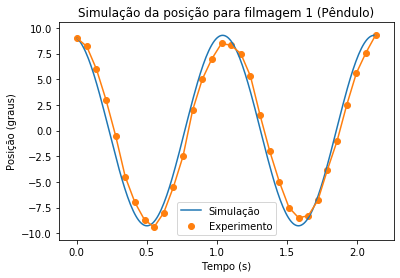

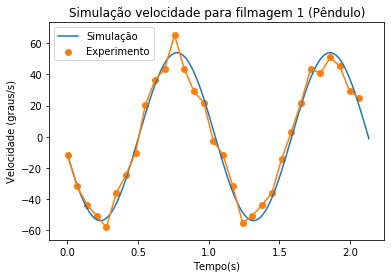

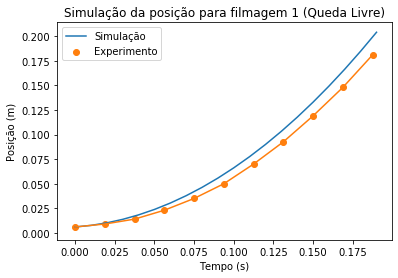

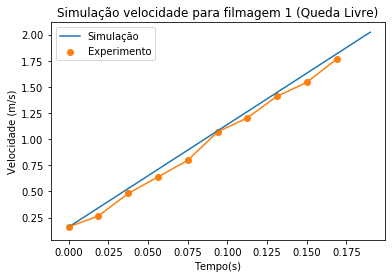

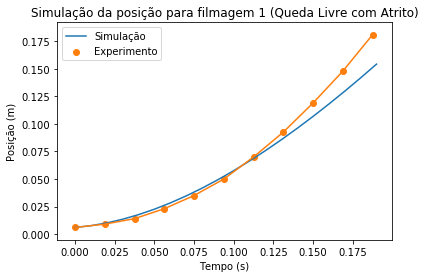

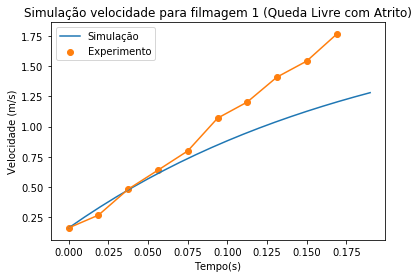

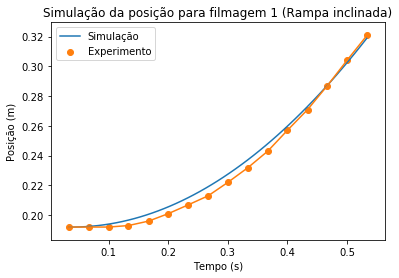

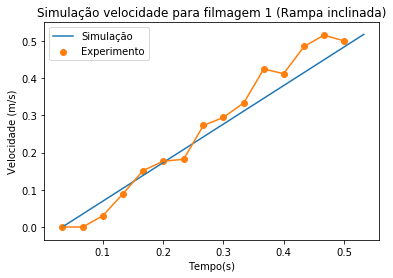

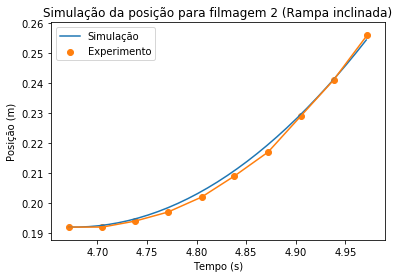

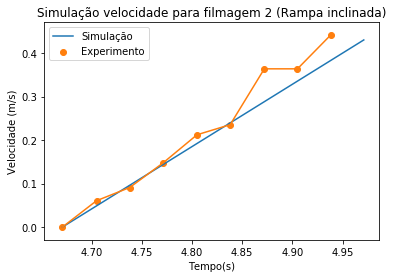

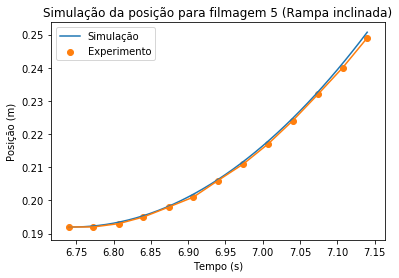

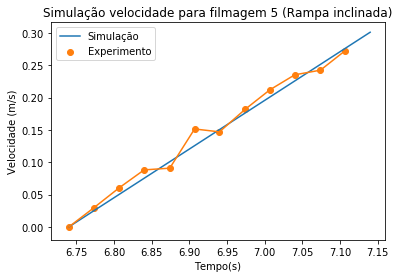

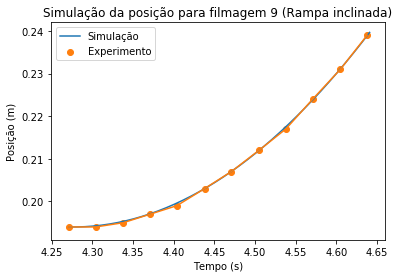

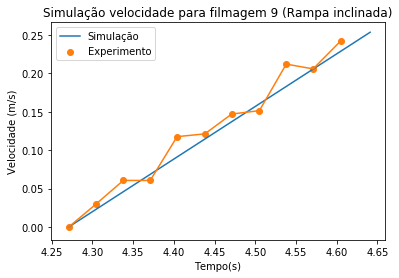

In [69]:
simulate(dfP, 'angle', 'Pêndulo', ratesPendulum, 'graus', 1)       
simulate(dfFF, 'position', 'Queda Livre', ratesFreeFall, 'm', 1)   
simulate(dfFF, 'position', 'Queda Livre com Atrito', ratesFreeFallWithDrag, 'm', 1)  
simulate(dfA, 'position', 'Rampa inclinada', getRatesSlope(0.23, dfA, 1), 'm', 1)  
simulate(dfA, 'position', 'Rampa inclinada', getRatesSlope(0.23, dfA, 2), 'm', 2)  
simulate(dfA, 'position', 'Rampa inclinada', getRatesSlope(0.19, dfA, 5), 'm', 5)
simulate(dfA, 'position', 'Rampa inclinada', getRatesSlope(0.187, dfA, 9), 'm', 9)

Vamos escrever testes para funções que não são de plot

In [50]:
import unittest

class TestNotebook(unittest.TestCase):

    def test_initSVTrajectory(self):
        self.assertEqual(initSVTrajectory(), [])
        
    def test_initStateVector(self):
        s1 = np.array([1,2,3])
        s2 = initStateVector([1,2,3])
        self.assertTrue((s1 == s2).all())
    
    def test_updateStateVectorEuler(self):
        def rateFunction(foo, boo):
            return np.array([1,2,3])
        
        s = np.array([1,2,3])
        s1 = updateStateVectorEuler(s,0,rateFunction)
        s2 = np.array([2,4,6])
        self.assertEqual(list(s1), list(s2))

    def test_updateSVTrajectory(self):
        s = [[1,2,3]]
        s1 = [[1,2,3], [4,5,6]]
        s2 = updateSVTrajectory(s, [4,5,6])
        self.assertEqual(s1, s2)
    
    def test_extractSVTrajectory(self):
        s = [[1,2,3], [4,5,6]]
        s1 = extractSVTrajectory(s, 1)
        self.assertEqual(list(s1), [2, 5])    

    def test_ratesFreeFall(self):
        
        s1 =  ratesFreeFall([1,2,3], 3)
        s2 = [6, 29.4, 3]

        for i in range(0, 3):
            self.assertAlmostEqual(s1[i], s2[i])
            
    def test_ratesFreeFallWithDrag(self):
        s1 = ratesFreeFallWithDrag([1,2,3], 3)
        s2 = [6, -0.6, 3]
        
        for i in range(0, 3):
            self.assertAlmostEqual(s1[i], s2[i])
    
    def test_ratesPendulum(self):
        s1 = ratesPendulum([1,2,3], 3)
        r1 = -9.8*(1*3)/(0.2905)
        r2 = 3
        r0 = (2 +  r1)*3
        s2 = [r0, r1, r2]
        
        for i in range(0, 3):
            self.assertAlmostEqual(s1[i], s2[i])
            
unittest.main(argv=[''], verbosity=2, exit=False)

test_extractSVTrajectory (__main__.TestNotebook) ... ok
test_initSVTrajectory (__main__.TestNotebook) ... ok
test_initStateVector (__main__.TestNotebook) ... ok
test_ratesFreeFall (__main__.TestNotebook) ... ok
test_ratesFreeFallWithDrag (__main__.TestNotebook) ... ok
test_ratesPendulum (__main__.TestNotebook) ... ok
test_updateSVTrajectory (__main__.TestNotebook) ... ok
test_updateStateVectorEuler (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 8 tests in 0.005s

OK
